# Setup & Imports

In [1]:
# 📦 Install dependencies
# Run this cell once to make sure all required packages are available

%pip install -q pandas numpy biopython matplotlib seaborn tqdm goatools plotly umap-learn scikit-learn torch transformers


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# GO Ontology
from goatools.obo_parser import GODag


In [3]:
# Define data paths
DATA_DIR = "./cafa-6-protein-function-prediction"
TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR = os.path.join(DATA_DIR, "Test")

print("Files in Train:", os.listdir(TRAIN_DIR))
print("Files in Test:", os.listdir(TEST_DIR))


Files in Train: ['train_taxonomy.tsv', 'train_terms.tsv', 'go-basic.obo', 'train_sequences.fasta']
Files in Test: ['testsuperset.fasta', 'testsuperset-taxon-list.tsv']


# 🧠 Explore Dataset Size and Structure

- Count the number of sequences in:

    - train_sequences.fasta

    - testsuperset.fasta

- Count unique proteins in train_terms.tsv and train_taxonomy.tsv

- Check if all sequence IDs match across files.

👉 Goal: Ensure internal consistency between FASTA, taxonomy, and term mapping files.

In [4]:
# Load TSV files
train_terms = pd.read_csv(os.path.join(TRAIN_DIR, "train_terms.tsv"), sep="\t")
train_taxonomy = pd.read_csv(
    os.path.join(TRAIN_DIR, "train_taxonomy.tsv"),
    sep="\t",
    header=None,
    names=["EntryID", "Taxon"]
)

IA = pd.read_csv(
    os.path.join(DATA_DIR, "IA.tsv"),
    sep="\t",
    header=None,
    names=["GO_ID", "InformationAccretion"]
)


print("train_terms:", train_terms.shape)
print("train_taxonomy:", train_taxonomy.shape)
print("IA:", IA.shape)


train_terms: (537027, 3)
train_taxonomy: (82404, 2)
IA: (40122, 2)


In [5]:
# Preview first few rows
display(train_terms.head())
display(train_taxonomy.head())
display(IA.head())


,EntryID,term,aspect
0,Q5W0B1,GO:0000785,C
1,Q5W0B1,GO:0004842,F
2,Q5W0B1,GO:0051865,P
3,Q5W0B1,GO:0006275,P
4,Q5W0B1,GO:0006513,P


,EntryID,Taxon
0,A0A0C5B5G6,9606
1,A0JNW5,9606
2,A0JP26,9606
3,A0PK11,9606
4,A1A4S6,9606


,GO_ID,InformationAccretion
0,GO:0000001,0.000000
1,GO:0000002,2.849666
2,GO:0000011,0.137504
3,GO:0000012,6.038630
4,GO:0000017,0.514573


## Count and Check Data Consistency

In [6]:
fasta_path = os.path.join(TRAIN_DIR, "train_sequences.fasta")
#  Unique protein IDs
def extract_uniprot_id(record_id):
    # e.g. "sp|Q9Y2Q0|ABC1_HUMAN" → "Q9Y2Q0"
    parts = record_id.split('|')
    if len(parts) >= 2:
        return parts[1]
    return record_id  # fallback if no pipe present

train_seq_ids = {extract_uniprot_id(record.id) for record in SeqIO.parse(fasta_path, "fasta")}
term_ids = set(train_terms['EntryID'])
tax_ids = set(train_taxonomy['EntryID'])

print(f"Sequences: {len(train_seq_ids)} | Terms: {len(term_ids)} | Taxonomy: {len(tax_ids)}")
print("Unmatched IDs (terms not in sequences):", len(term_ids - train_seq_ids))

Sequences: 82404 | Terms: 82404 | Taxonomy: 82404
Unmatched IDs (terms not in sequences): 0


### Sequence Length Distribution

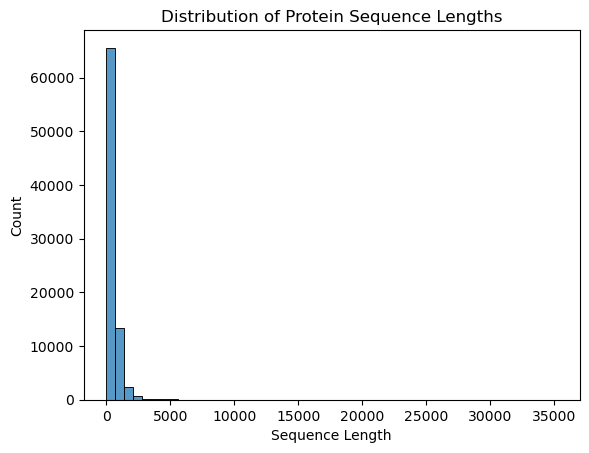

In [7]:
seq_lengths = [len(record.seq) for record in SeqIO.parse(fasta_path, "fasta")]
sns.histplot(seq_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Protein Sequence Lengths")
plt.show()


The histogram is extremely right-skewed — most proteins have short sequences (clustered near the left), and a few are very long (creating a “long tail”).

### Plotting After Remove statistical outliers

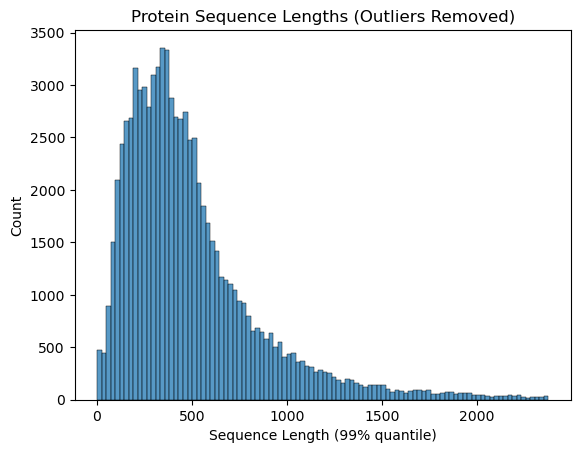

In [8]:
import numpy as np

lengths = np.array(seq_lengths)
filtered_lengths = lengths[lengths < np.percentile(lengths, 99)]  # keep 99% shortest

sns.histplot(filtered_lengths, bins=100)
plt.xlabel("Sequence Length (99% quantile)")
plt.ylabel("Count")
plt.title("Protein Sequence Lengths (Outliers Removed)")
plt.show()


### Overview for Sequence Distribution

In [9]:
print("Min length:", np.min(seq_lengths))
print("Median length:", np.median(seq_lengths))
print("Mean length:", np.mean(seq_lengths))
print("95th percentile:", np.percentile(seq_lengths, 95))
print("Max length:", np.max(seq_lengths))

Min length: 3
Median length: 409.0
Mean length: 525.7882869763604
95th percentile: 1318.0
Max length: 35213


## Number of GO Terms per Protein

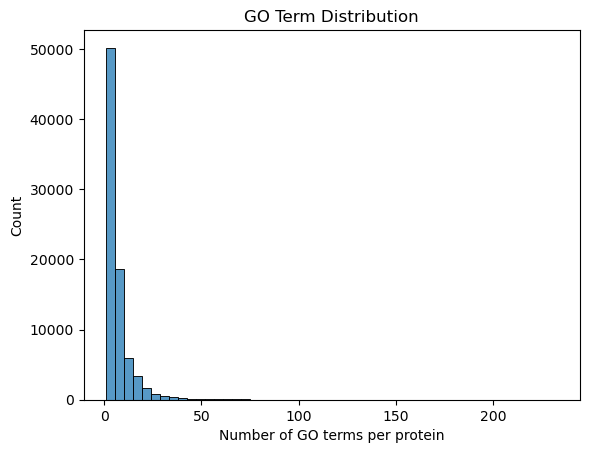

In [10]:
go_counts = train_terms.groupby('EntryID')['term'].count()
sns.histplot(go_counts, bins=50)
plt.xlabel("Number of GO terms per protein")
plt.ylabel("Count")
plt.title("GO Term Distribution")
plt.show()


In [11]:
print("Min length:", np.min(go_counts))
print("Median length:", np.median(go_counts))
print("Mean length:", np.mean(go_counts))
print("95th percentile:", np.percentile(go_counts, 95))
print("Max length:", np.max(go_counts))

# Find the protein with the highest number of GO terms
max_go_count = go_counts.max()
top_proteins = go_counts[go_counts == max_go_count]
print(f"Number of proteins with {max_go_count} GO terms: {len(top_proteins)}")
print(top_proteins)


Min length: 1
Median length: 4.0
Mean length: 6.517001601863988
95th percentile: 20.0
Max length: 233
Number of proteins with 233 GO terms: 1
EntryID
Q02248    233
Name: term, dtype: int64


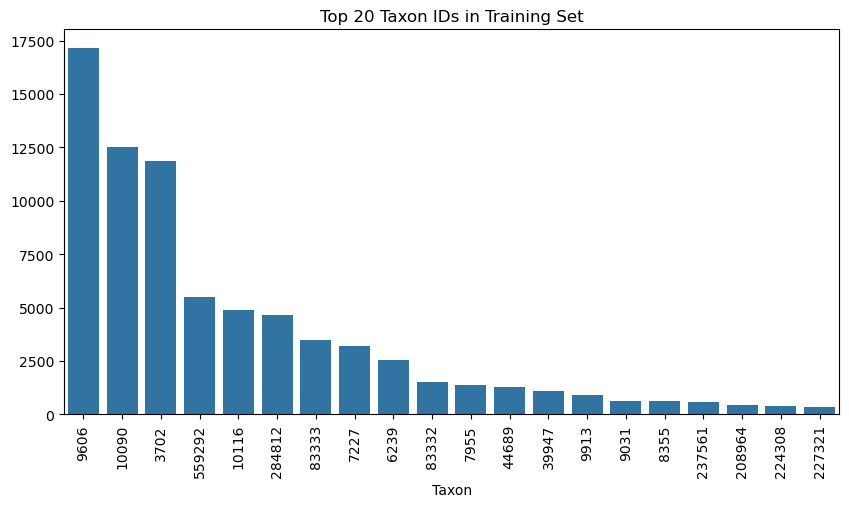

In [12]:
tax_counts = train_taxonomy['Taxon'].value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(x=tax_counts.index.astype(str), y=tax_counts.values)
plt.xticks(rotation=90)
plt.title("Top 20 Taxon IDs in Training Set")
plt.show()


# Feature Extraction

### Amino Acid Distribution

In [13]:
# Compute amino acid composition for first 100 sequences (as demo)
records = list(SeqIO.parse(fasta_path, "fasta"))[:100]

features = []
for record in tqdm(records):
    seq = str(record.seq)
    analysis = ProteinAnalysis(seq)
    aa_freq = analysis.get_amino_acids_percent()
    features.append({
        "id": extract_uniprot_id(record.id),
        "length": len(seq),
        **aa_freq
    })

aa_df = pd.DataFrame(features)
aa_df.head()


100%|██████████| 100/100 [00:00<00:00, 36967.25it/s]


,id,length,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,A0A0C5B5G6,16,0.000000,0.000000,0.000000,0.062500,0.062500,0.062500,0.000000,0.062500,...,0.125000,0.000000,0.062500,0.062500,0.187500,0.000000,0.000000,0.000000,0.062500,0.125000
1,A0JNW5,1464,0.049863,0.017077,0.060109,0.066940,0.035519,0.037568,0.032787,0.057377,...,0.023907,0.053279,0.045765,0.047814,0.034836,0.120902,0.058060,0.056011,0.008197,0.023907
2,A0JP26,581,0.053356,0.037866,0.063683,0.092943,0.015491,0.056799,0.034423,0.036145,...,0.030981,0.060241,0.027539,0.051635,0.049914,0.080895,0.037866,0.046472,0.008606,0.017212
3,A0PK11,232,0.107759,0.021552,0.021552,0.051724,0.064655,0.073276,0.021552,0.081897,...,0.017241,0.025862,0.030172,0.038793,0.025862,0.056034,0.030172,0.107759,0.021552,0.025862
4,A1A4S6,786,0.058524,0.013995,0.047074,0.090331,0.053435,0.049618,0.026718,0.045802,...,0.022901,0.044529,0.063613,0.043257,0.055980,0.080153,0.053435,0.052163,0.008906,0.021628


In [14]:
aa_df.describe().T


,count,mean,std,min,25%,50%,75%,max
length,100.0,552.190000,506.741655,16.000000,251.500000,393.000000,651.250000,2624.000000
A,100.0,0.069425,0.028376,0.000000,0.049162,0.068247,0.084625,0.164977
C,100.0,0.023600,0.023046,0.000000,0.010568,0.019079,0.026857,0.139847
D,100.0,0.046845,0.016378,0.000000,0.037125,0.045602,0.056851,0.100358
E,100.0,0.065139,0.025273,0.013667,0.050252,0.062910,0.078612,0.148485
F,100.0,0.039738,0.021199,0.000000,0.023087,0.038680,0.053477,0.104348
G,100.0,0.069064,0.023779,0.000000,0.051096,0.067117,0.079861,0.142336
H,100.0,0.024910,0.011073,0.000000,0.018071,0.024264,0.031806,0.059259
I,100.0,0.046547,0.020702,0.006645,0.033545,0.045247,0.058729,0.113895
K,100.0,0.055267,0.023638,0.008696,0.039383,0.054300,0.071051,0.148936


### Correlation between Sequence Length & Go Terms

In [15]:
# 1️⃣ Build a DataFrame for sequence lengths
seq_data = []
for record in SeqIO.parse(fasta_path, "fasta"):
    seq_data.append({"EntryID": extract_uniprot_id(record.id), "SeqLength": len(record.seq)})

seq_df = pd.DataFrame(seq_data)

# 2️⃣ Convert GO counts to a DataFrame
go_count_df = go_counts.reset_index()
go_count_df.columns = ["EntryID", "GO_Count"]

# 3️⃣ Merge them together
merged_df = pd.merge(seq_df, go_count_df, on="EntryID", how="inner")

print("Merged shape:", merged_df.shape)
merged_df.head()

Merged shape: (82404, 3)


,EntryID,SeqLength,GO_Count
0,A0A0C5B5G6,16,14
1,A0JNW5,1464,8
2,A0JP26,581,1
3,A0PK11,232,2
4,A1A4S6,786,5


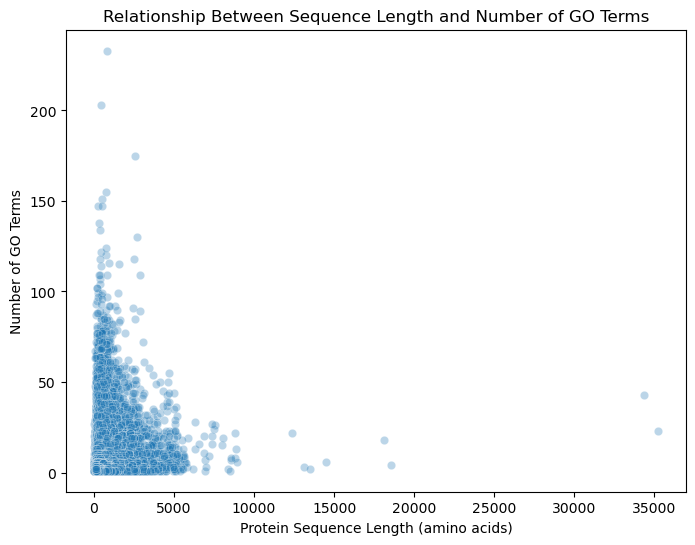

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="SeqLength", y="GO_Count", data=merged_df, alpha=0.3)
plt.xlabel("Protein Sequence Length (amino acids)")
plt.ylabel("Number of GO Terms")
plt.title("Relationship Between Sequence Length and Number of GO Terms")
plt.show()

In [17]:
pearson_corr = merged_df["SeqLength"].corr(merged_df["GO_Count"], method="pearson")
spearman_corr = merged_df["SeqLength"].corr(merged_df["GO_Count"], method="spearman")

print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")


Pearson correlation: 0.139
Spearman correlation: 0.182


- Longer proteins tend to have slightly more GO annotations, but the relationship is weak.

- Most proteins are relatively short (a few hundred amino acids) and annotated with only a handful of GO terms.

- Some large, multifunctional proteins (like chaperones or large enzymes) do have many GO terms, but they’re rare and not enough to produce a strong correlation.

- The small positive Spearman correlation suggests that as sequence length increases, the rank of GO term count also tends to increase slightly — consistent with multi-domain or complex proteins having more diverse functions.

# Gene Ontology Analysis

In [18]:
go = GODag(os.path.join(TRAIN_DIR, "go-basic.obo"))
print(f"Number of GO terms parsed: {len(go)}")


./cafa-6-protein-function-prediction/Train/go-basic.obo: fmt(1.2) rel(2025-06-01) 43,448 Terms
Number of GO terms parsed: 43448


In [19]:
# Count categories (BP, MF, CC)
from collections import Counter
aspect_counts = Counter(term.namespace for term in go.values())
aspect_counts

Counter({'biological_process': 27975,
         'molecular_function': 11204,
         'cellular_component': 4269})

### Distribution of GO Term Counts per Taxonomy, Grouped by GO Aspect (Top 10 Taxonomies)

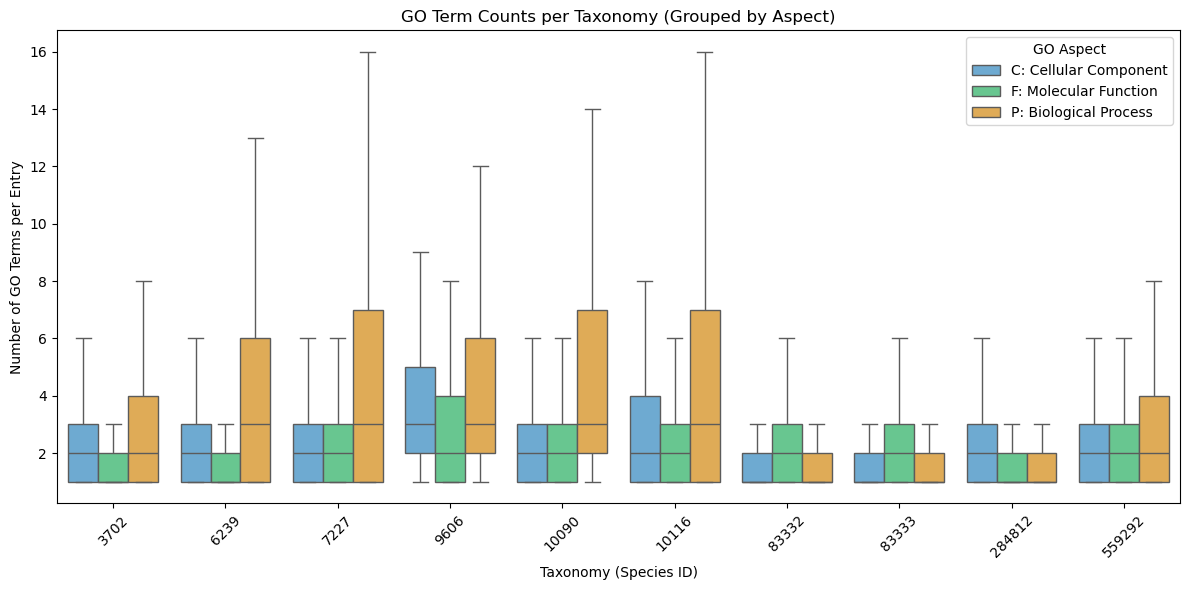

In [20]:
# Count number of unique GO terms per Entry, grouped by aspect
# This calculates how many GO terms each protein has in each aspect type (C, F, P)
go_counts_aspect = train_terms.groupby(['EntryID', 'aspect'])['term'].nunique().reset_index()
go_counts_aspect.rename(columns={'term': 'GO_count'}, inplace=True)

# Merge with taxonomy information to know which species each protein belongs to
merged_df_aspect = pd.merge(go_counts_aspect, train_taxonomy, on='EntryID', how='left')

# Focus on the top 10 most common taxonomies (to keep the plot readable)
top_taxa = merged_df_aspect['Taxon'].value_counts().nlargest(10).index
subset = merged_df_aspect[merged_df_aspect['Taxon'].isin(top_taxa)]

# Define custom color palette for each GO aspect
# You can adjust the hex codes if you prefer different colors
custom_palette = {
    'C': '#5DADE2',   # Blue  → Cellular Component
    'F': '#58D68D',   # Green → Molecular Function
    'P': '#F5B041'    # Orange → Biological Process
}

# Create a grouped box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=subset,
    x='Taxon',
    y='GO_count',
    hue='aspect',
    hue_order=['C', 'F', 'P'],      # ensure consistent color order
    showfliers=False,               # hide outliers for cleaner view
    palette=custom_palette          # apply custom colors
)

# Fix legend colors and labels (must be called AFTER plotting)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles,
    ['C: Cellular Component', 'F: Molecular Function', 'P: Biological Process'],
    title='GO Aspect'
)

# Improve plot readability
plt.xticks(rotation=45)
plt.xlabel('Taxonomy (Species ID)')
plt.ylabel('Number of GO Terms per Entry')
plt.title('GO Term Counts per Taxonomy (Grouped by Aspect)')
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
def load_fasta_sequences(file_path):
    """Return dict {protein_id: sequence}"""
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        prot_id = record.id.split("|")[1] if "|" in record.id else record.id
        sequences[prot_id] = str(record.seq)
    return sequences

train_sequences = load_fasta_sequences(f"{TRAIN_DIR}/train_sequences.fasta")
test_sequences = load_fasta_sequences(f"{TEST_DIR}/testsuperset.fasta")

print(f"Train sequences: {len(train_sequences)}")
print(f"Test superset sequences: {len(test_sequences)}")



Train sequences: 82404
Test superset sequences: 224309


In [22]:
import torch
from transformers import AutoTokenizer, AutoModel
from Bio import SeqIO
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [24]:
MODEL_NAME = "facebook/esm2_t6_8M_UR50D"  # small and fast baseline
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print(f"✅ Loaded {MODEL_NAME} on {device}")


Invalid URL '/api/resolve-cache/models/facebook/esm2_t6_8M_UR50D/c731040fcd8d73dceaa04b0a8e6329b345b0f5df/config.json?%2Ffacebook%2Fesm2_t6_8M_UR50D%2Fresolve%2Fmain%2Fconfig.json=&etag=%22c2c6e65a87d9d20d47699ae236d605b80c741dd3%22': No scheme supplied. Perhaps you meant https:///api/resolve-cache/models/facebook/esm2_t6_8M_UR50D/c731040fcd8d73dceaa04b0a8e6329b345b0f5df/config.json?%2Ffacebook%2Fesm2_t6_8M_UR50D%2Fresolve%2Fmain%2Fconfig.json=&etag=%22c2c6e65a87d9d20d47699ae236d605b80c741dd3%22?


OSError: Can't load config for 'facebook/esm2_t6_8M_UR50D'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'facebook/esm2_t6_8M_UR50D' is the correct path to a directory containing a config.json file

In [9]:
def get_protein_embedding(sequence: str):
    """Return mean pooled embedding for one protein sequence."""
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=1022)
    with torch.no_grad():
        outputs = model(**{k: v.to(device) for k, v in inputs.items()})
    # Mean-pool across tokens (excluding [CLS], [EOS])
    emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return emb

In [ ]:
train_fasta_path =f"{TRAIN_DIR}/train_sequences.fasta"  # Path to the test FASTA file
train_sequences = {record.id: str(record.seq) for record in SeqIO.parse(train_fasta_path, "fasta")}

seq_items = list(train_sequences.items())
train_embeddings = []
train_protein_ids = []

for prot_id, seq in tqdm(seq_items, desc="Embedding test proteins"):
    try:
        emb = get_protein_embedding(seq)
        train_embeddings.append(emb)
        train_protein_ids.append(prot_id)
    except Exception as e:
        print(f"⚠️ Skipped {prot_id}: {e}")

# ---------------------------------------------------------
# Save test embeddings
# ---------------------------------------------------------
train_emb_df = pd.DataFrame(train_embeddings)
train_emb_df.insert(0, "protein_id", train_protein_ids)
train_emb_df.to_parquet("train_esm2_embeddings.parquet", index=False)

print(f"\n✅ Saved {len(train_emb_df)} test protein embeddings with shape {train_emb_df.shape}")
display(train_emb_df.head())

Embedding test proteins:   0%|          | 0/82404 [00:00<?, ?it/s]


✅ Saved 82404 test protein embeddings with shape (82404, 321)


,protein_id,0,1,2,3,4,5,6,7,8,...,310,311,312,313,314,315,316,317,318,319
0,sp|A0A0C5B5G6|MOTSC_HUMAN,0.016995,-0.289623,0.220576,0.400105,0.027324,-0.284063,-0.224509,-0.003665,-0.097631,...,-0.025162,-0.092082,0.048782,0.085236,0.102798,0.190836,0.062706,0.037373,0.223802,-0.019890
1,sp|A0JNW5|BLT3B_HUMAN,-0.039587,-0.061474,0.023377,-0.077046,0.072627,-0.134267,-0.090827,-0.012651,-0.036656,...,0.197124,-0.120535,0.185727,0.228988,0.050624,0.102817,-0.109002,0.181194,-0.013855,0.103747
2,sp|A0JP26|POTB3_HUMAN,-0.192109,-0.266274,0.000874,0.143708,-0.088105,-0.122343,0.079432,-0.025152,-0.046349,...,0.089531,0.031170,0.050620,0.252825,-0.032866,0.219300,-0.166957,0.268222,-0.168766,-0.007726
3,sp|A0PK11|CLRN2_HUMAN,0.008471,-0.014142,0.175401,0.166669,-0.125394,-0.021472,-0.099630,0.003798,-0.160506,...,-0.002182,0.065093,0.085836,-0.038845,0.052836,-0.095500,-0.050917,-0.049219,0.068254,0.160382
4,sp|A1A4S6|RHG10_HUMAN,-0.121621,-0.130025,0.021453,0.017849,0.043629,-0.142089,0.021906,0.057227,-0.042524,...,0.200141,-0.098818,0.056475,0.225103,0.084839,-0.021158,0.012474,0.199604,-0.080447,0.092936


In [14]:
# ---------------------------------------------------------
# Function to compute mean-pooled embeddings
# ---------------------------------------------------------
def get_protein_embedding(sequence: str):
    """Return mean pooled embedding for one protein sequence."""
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=1022)
    with torch.no_grad():
        outputs = model(**{k: v.to(device) for k, v in inputs.items()})
    # Mean-pool across tokens (excluding [CLS], [EOS])
    emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return emb

# ---------------------------------------------------------
# Compute embeddings for all test sequences
# ---------------------------------------------------------
test_fasta_path = 'cafa-6-protein-function-prediction/Test/testsuperset.fasta'  # Path to the test FASTA file
test_sequences = {record.id: str(record.seq) for record in SeqIO.parse(test_fasta_path, "fasta")}

# You can limit to first N for quick testing

seq_items = list(test_sequences.items())
test_embeddings = []
test_protein_ids = []

for prot_id, seq in tqdm(seq_items, desc="Embedding test proteins"):
    try:
        emb = get_protein_embedding(seq)
        test_embeddings.append(emb)
        test_protein_ids.append(prot_id)
    except Exception as e:
        print(f"⚠️ Skipped {prot_id}: {e}")

# ---------------------------------------------------------
# Save test embeddings
# ---------------------------------------------------------
test_emb_df = pd.DataFrame(test_embeddings)
test_emb_df.insert(0, "protein_id", test_protein_ids)
test_emb_df.to_parquet("test_esm2_embeddings.parquet", index=False)

print(f"\n✅ Saved {len(test_emb_df)} test protein embeddings with shape {test_emb_df.shape}")
display(test_emb_df.head())

Embedding test proteins:   0%|          | 0/224309 [00:00<?, ?it/s]


✅ Saved 224309 test protein embeddings with shape (224309, 321)


,protein_id,0,1,2,3,4,5,6,7,8,...,310,311,312,313,314,315,316,317,318,319
0,A0A0C5B5G6,0.016995,-0.289623,0.220576,0.400105,0.027324,-0.284063,-0.224509,-0.003665,-0.097631,...,-0.025162,-0.092082,0.048782,0.085236,0.102798,0.190836,0.062706,0.037373,0.223802,-0.019890
1,A0A1B0GTW7,-0.092942,-0.253180,0.013043,0.142711,0.165451,-0.181126,0.186943,0.115521,-0.012884,...,0.186031,-0.005595,0.032572,0.167564,-0.073868,0.021206,0.093485,0.146423,0.065757,0.040867
2,A0JNW5,-0.039587,-0.061474,0.023377,-0.077046,0.072627,-0.134267,-0.090827,-0.012651,-0.036656,...,0.197124,-0.120535,0.185727,0.228988,0.050624,0.102817,-0.109002,0.181194,-0.013855,0.103747
3,A0JP26,-0.192109,-0.266274,0.000874,0.143708,-0.088105,-0.122343,0.079432,-0.025152,-0.046349,...,0.089531,0.031170,0.050620,0.252825,-0.032866,0.219300,-0.166957,0.268222,-0.168766,-0.007726
4,A0PK11,0.008471,-0.014142,0.175401,0.166669,-0.125394,-0.021472,-0.099630,0.003798,-0.160506,...,-0.002182,0.065093,0.085836,-0.038845,0.052836,-0.095500,-0.050917,-0.049219,0.068254,0.160382


In [ ]:
# GO Terms Analysis
from collections import Counter

data = Counter(train_terms['term'])
freqs = np.array(list(data.values()))
percentile_99 = np.percentile(freqs, 1)  # bottom 1% threshold (1st percentile)
print("1st percentile cutoff (bottom 1% frequency) =", percentile_99)
rare_terms = {term for term, c in data.items() if c <= percentile_99}
print("Number of rare GO terms:", len(rare_terms))
print(len(train_terms['term'].unique()))

# mapping: term → list of sequences
from collections import defaultdict

term_to_seqs = defaultdict(set)

for seq, term in zip(train_terms['EntryID'], train_terms['term']):
    term_to_seqs[term].add(seq)

# Only terms that map to exactly 1 sequence
terms_in_one_sequence = {t for t, seqs in term_to_seqs.items() if len(seqs) == 1}

# mapping: sequence → list of terms
seq_to_terms = defaultdict(set)

for seq, term in zip(train_terms['EntryID'], train_terms['term']):
    seq_to_terms[seq].add(term)

unique_1to1_pairs = []

for term in rare_terms & terms_in_one_sequence:   # intersection
    seq = list(term_to_seqs[term])[0]  # the only sequence
    
    # check if the sequence has ONLY this GO term
    if seq_to_terms[seq] == {term}:
        unique_1to1_pairs.append((seq, term))

print("Number of 1-to-1 sequence ↔ rare GO term pairs:", len(unique_1to1_pairs))
unique_1to1_pairs[:10]



1st percentile cutoff (bottom 1% frequency) = 1.0
Number of rare GO terms: 5377
26125
Number of 1-to-1 sequence ↔ rare GO term pairs: 79


TypeError: object of type 'numpy.float64' has no len()

In [40]:
from collections import defaultdict

def go_dimension_analysis(train_terms, percentiles=[1,5,10,20,50,60,70,80,90,95,99]):
    term_counts = Counter(train_terms['term'])
    freqs = np.array(list(term_counts.values()))
    
    # Build mappings
    term_to_seqs = defaultdict(set)
    seq_to_terms = defaultdict(set)
    
    for seq, term in zip(train_terms['EntryID'], train_terms['term']):
        term_to_seqs[term].add(seq)
        seq_to_terms[seq].add(term)

    results = []

    for p in percentiles:
        cutoff = np.percentile(freqs, p)
        
        # keep terms above the cutoff
        kept_terms = {t for t, c in term_counts.items() if c > cutoff}
        removed_terms = set(term_counts.keys()) - kept_terms
        
        # sequences that still have at least 1 GO term
        kept_sequences = sum(1 for seq, terms in seq_to_terms.items()
                             if len(terms & kept_terms) > 0)
        
        total_sequences = len(seq_to_terms)
        
        # 1-to-1 rare GO terms
        removed_1to1 = [
            (term, list(term_to_seqs[term])[0])
            for term in removed_terms
            if len(term_to_seqs[term]) == 1 and   # GO term maps to 1 sequence
               len(seq_to_terms[list(term_to_seqs[term])[0]]) == 1  # sequence only has this GO term
        ]
        
        results.append({
            "percentile": p,
            "cutoff_frequency": cutoff,
            "terms_kept": len(kept_terms),
            "terms_removed": len(removed_terms),
            "sequences_kept": kept_sequences,
            "sequences_lost": total_sequences - kept_sequences,
            "lost_1to1_pairs": len(removed_1to1),
        })

    return results
results = go_dimension_analysis(train_terms)
import pandas as pd
pd.DataFrame(results)


,percentile,cutoff_frequency,terms_kept,terms_removed,sequences_kept,sequences_lost,lost_1to1_pairs
0,1,1.0,20748,5377,82314,90,79
1,5,1.0,20748,5377,82314,90,79
2,10,1.0,20748,5377,82314,90,79
3,20,1.0,20748,5377,82314,90,79
4,50,4.0,13039,13086,81903,501,79
5,60,6.0,10362,15763,81576,828,79
6,70,10.0,7257,18868,80903,1501,79
7,80,15.0,5214,20911,80161,2243,79
8,90,32.0,2532,23593,77949,4455,79
9,95,57.0,1305,24820,75826,6578,79


Best Cutoff: 60%